# Feature detection

In this notebook we are going to have a detailed look at the feature detection of tobac and explore the parameters of the according function.

In [8]:
import tobac
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

%matplotlib inline

## Minima/Maxima and multiple thresholds

When working different inputs it is sometimes necessary to switch the feature detection from finding maxima to minima. Furthermore, for more complex datasets containing multiple features differing in magnitude, a categorization according to this magnitude is desirable. Both will be demonstrated with the *make_sample_data_2D_3blobs()* function, which creates such a dataset. For the search for minima we will simply turn the dataset negative:

In [9]:
data = tobac.testing.make_sample_data_2D_3blobs()
neg_data = -data

Let us have a look at frame number 50:

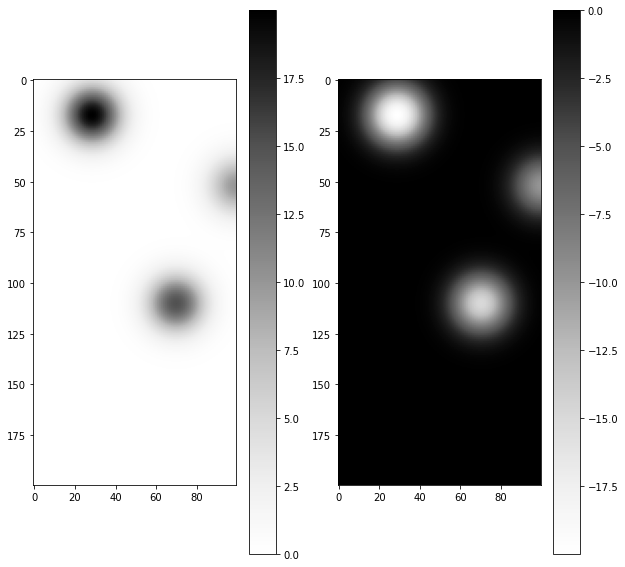

In [10]:
n = 50

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (10, 10))

im1 = ax1.imshow(data.data[50], cmap = 'Greys')
cbar = plt.colorbar(im1, ax = ax1)

im2 = ax2.imshow(neg_data.data[50], cmap = 'Greys')
cbar = plt.colorbar(im2, ax = ax2)

As you can see the data has 3 maxima/minima with different extremal values. To capture these, we use list comprehensions to obtain multiple thresholds:

In [11]:
thresholds = [i for i in range(9, 18)]
inv_thresholds = [-i for i in range(9, 18)]

These can now be passed as arguments to *feature_detection_multithreshold()*. With the *target*-keyword we can set a flag whether to search for minima or maxima. The standard is *'maxima'*.

In [12]:
%%capture

dxy, dt = tobac.utils.get_spacings(data)

features = tobac.themes.tobac_v1.feature_detection_multithreshold(data, dxy, thresholds, target = 'maximum')
features_inv = tobac.themes.tobac_v1.feature_detection_multithreshold(neg_data, dxy, inv_thresholds, target = 'minimum')

Let's scatter the found features onto frame 50 and create colorbars for threshold values:

Text(0, 0.5, 'threshold')

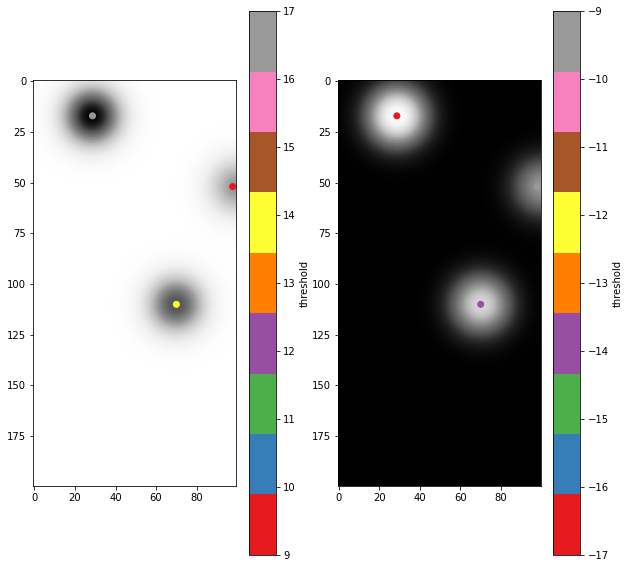

In [14]:
mask_1 = features['frame'] == n
mask_2 = features_inv['frame'] == n

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (10, 10))

ax1.imshow(data.data[50], cmap = 'Greys')
im1 = ax1.scatter(features.where(mask_1)['hdim_2'], features.where(mask_1)['hdim_1'], c = features.where(mask_1)['threshold_value'], cmap = 'Set1')
cbar = plt.colorbar(im1, ax = ax1)
cbar.ax.set_ylabel('threshold')

ax2.imshow(neg_data.data[50], cmap = 'Greys')
im2 = ax2.scatter(features_inv.where(mask_2)['hdim_2'], features_inv.where(mask_2)['hdim_1'], c = features_inv.where(mask_2)['threshold_value'], cmap = 'Set1')
cbar = plt.colorbar(im2, ax = ax2)
cbar.ax.set_ylabel('threshold')

## Feature position

To explore the influence of the position_threshold flag we need an asymmetric dataset. Let's create a simple one by adding two 2d-gausians and add an extra dimension for the time, which is required for working with tobac:

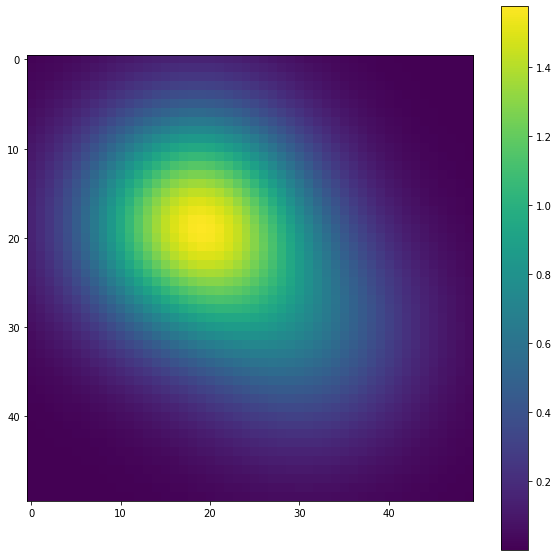

In [16]:
x = np.linspace(-2, 2)
y = np.linspace(-2, 2)
xx, yy = np.meshgrid(x, y)

exp1 = 1.5*np.exp(-((xx+0.5)**2+(yy+0.5)**2))
exp2 = 0.5*np.exp(-((0.5-xx)**2+(0.5-yy)**2))

asymmetric_data = np.expand_dims(exp1 + exp2, axis=0)

plt.figure(figsize=(10,10))
plt.imshow(asymmetric_data[0])
plt.colorbar()

To feed this data into the feature detection we need to convert it into an xarray-DataArray. Before we do that we we select an arbitrary time and date for the single frame of our synthetic field:

In [17]:
date = np.datetime64('2022-04-01T00:00', )
assym = xr.DataArray(data=asymmetric_data, coords={'time':np.expand_dims(date, axis = 0),'y':y, 'x':x})
assym

<xarray.DataArray (time: 1, y: 50, x: 50)>
array([[[0.01666536, 0.02114886, 0.02648334, ..., 0.00083392,
         0.00058509, 0.00040694],
        [0.02114886, 0.02683866, 0.03360844, ..., 0.00109464,
         0.00077154, 0.0005393 ],
        [0.02648334, 0.03360844, 0.04208603, ..., 0.00142435,
         0.00100896, 0.00070907],
        ...,
        [0.00083392, 0.00109464, 0.00142435, ..., 0.01405279,
         0.01121917, 0.00883872],
        [0.00058509, 0.00077154, 0.00100896, ..., 0.01121917,
         0.00895731, 0.00705704],
        [0.00040694, 0.0005393 , 0.00070907, ..., 0.00883872,
         0.00705704, 0.00556009]]])
Coordinates:
  * time     (time) datetime64[ns] 2022-04-01
  * y        (y) float64 -2.0 -1.918 -1.837 -1.755 ... 1.755 1.837 1.918 2.0
  * x        (x) float64 -2.0 -1.918 -1.837 -1.755 ... 1.755 1.837 1.918 2.0

Since we do not have a dt in this dataset, we can not use the get_spacings-utility this time and need to calculate the spacing manually:

In [18]:
dxy = (assym['x'][1] - assym['x'][0])

Finally, we choose a threshold in the datarange and apply the feature detection with the four position_threshold flags
- 'center'
- 'extreme'
- 'weighted_diff'
- 'weighted_diff'

In [33]:
%%capture

threshold = 0.5
features_center = tobac.themes.tobac_v1.feature_detection_multithreshold(assym, dxy, threshold, position_threshold='center')
features_extreme = tobac.themes.tobac_v1.feature_detection_multithreshold(assym, dxy, threshold, position_threshold='extreme')
features_diff = tobac.themes.tobac_v1.feature_detection_multithreshold(assym, dxy, threshold, position_threshold='weighted_diff')
features_abs = tobac.themes.tobac_v1.feature_detection_multithreshold(assym, dxy, threshold, position_threshold='weighted_diff')                       

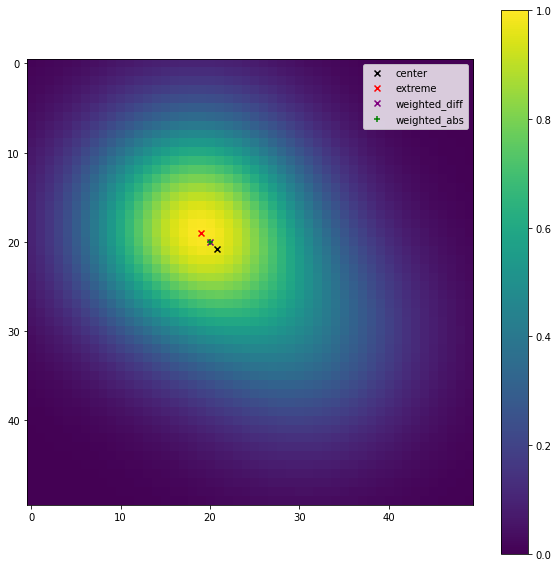

In [34]:
plt.figure(figsize = (10, 10))
plt.imshow(assym[0])
plt.scatter(features_center['hdim_2'], features_center['hdim_1'], color = 'black', marker = 'x', label = 'center')
plt.scatter(features_extreme['hdim_2'], features_extreme['hdim_1'], color = 'red', marker = 'x', label = 'extreme')
plt.scatter(features_diff['hdim_2'], features_diff['hdim_1'], color = 'purple', marker = 'x', label = 'weighted_diff')
plt.scatter(features_abs['hdim_2'], features_abs['hdim_1'], color = 'green', marker = '+', label = 'weighted_abs')
plt.colorbar()
plt.legend()

- extreme: highest value within the area above the threshold
- center : geometrical center of the area above the threshold
- weighted: mixture of both ??? HOw?

## Sigma threshold

Before the features are searched a gausian filter is applied to the data in order to smooth it. The effect of this filter can best be demonstrated on very sharp edges in the data. So let's import it and create an array from a boolean mask of our asymmetric data, which only has values of 0 or 1:

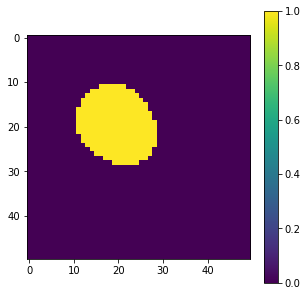

In [60]:
from scipy.ndimage.filters import gaussian_filter

x = np.linspace(-2, 2)
y = np.linspace(-2, 2)
xx, yy = np.meshgrid(x, y)

exp1 = 1.5*np.exp(-((xx+0.5)**2+(yy+0.5)**2))
exp2 = 0.5*np.exp(-((0.5-xx)**2+(0.5-yy)**2))

asymmetric_data = np.expand_dims(exp1 + exp2, axis=0)
data = np.array(asymmetric_data > 1, dtype = 'float32')

plt.figure(figsize=(5,5))
plt.imshow(data[0])
plt.colorbar()

If we apply this filter to the data with increasing sigmas, increasingly smoothed data will be the result:

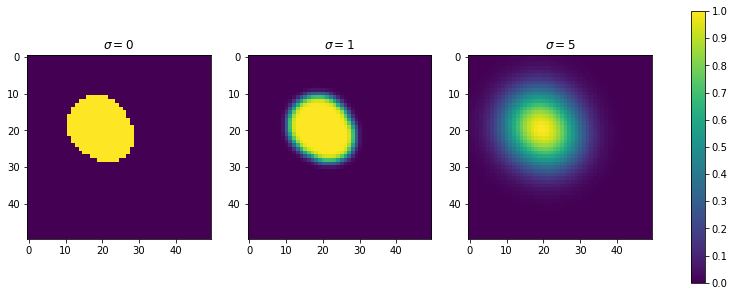

In [47]:
non_smooth_data = gaussian_filter(data, sigma=0)
smooth_data = gaussian_filter(data, sigma=1)
smoother_data = gaussian_filter(data, sigma=5)

fig, axes = plt.subplots(ncols = 3, figsize = (14, 10))

im0 = axes[0].imshow(non_smooth_data[0])
axes[0].set_title(r'$\sigma = 0$')

im1 = axes[1].imshow(smooth_data[0])
axes[1].set_title(r'$\sigma = 1$')

im2 = axes[2].imshow(smoother_data[0])
axes[2].set_title(r'$\sigma = 5$')

cbar = fig.colorbar(im1, ax = axes.tolist(), shrink = 0.5)
cbar.set_ticks(np.linspace(0, 1, 11))

This is what happens in the background, when the *feature_detection_multithreshold()* function is called. The default value of *simga_threshold* is 0.5. The next step is trying to detect features an the original dataset with the same *sigma_threshold* values. We first need an xarray DataArry again:

In [71]:
date = np.datetime64('2022-04-01T00:00' )
input_data = xr.DataArray(data=data, coords={'time':np.expand_dims(date, axis = 0),'y':y, 'x':x})

Now we set a threshold and detect the features:

In [67]:
%%capture

threshold = 0.8
features_sharp = tobac.themes.tobac_v1.feature_detection_multithreshold(input_data, dxy, threshold, sigma_threshold=0)
features_smooth = tobac.themes.tobac_v1.feature_detection_multithreshold(input_data, dxy, threshold, sigma_threshold=1)
features_smoother = tobac.themes.tobac_v1.feature_detection_multithreshold(input_data, dxy, threshold, sigma_threshold=5)

Attempting to plot the results

TypeError: 'NoneType' object is not subscriptable

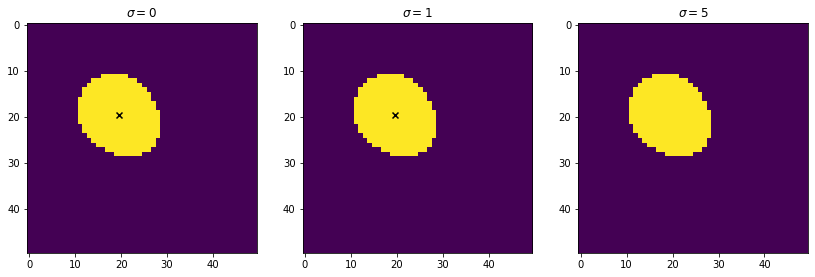

In [68]:
fig, axes = plt.subplots(ncols = 3, figsize = (14, 10))

im0 = axes[0].imshow(data[0])
axes[0].set_title(r'$\sigma = 0$')
axes[0].scatter(features_sharp['hdim_2'], features_sharp['hdim_1'], color = 'black', marker = 'x')

im0 = axes[1].imshow(data[0])
axes[1].set_title(r'$\sigma = 1$')
axes[1].scatter(features_smooth['hdim_2'], features_smooth['hdim_1'], color = 'black', marker = 'x')

im0 = axes[2].imshow(data[0])
axes[2].set_title(r'$\sigma = 5$')
axes[2].scatter(features_smoother['hdim_2'], features_smoother['hdim_1'], color = 'black', marker = 'x')


stops with an error for the last value of sigma, since no features where detected there. The reason for this is that the data has been smoothed to such an extent that no value exceeds the threshold value any more, which can be verified by looking at the maximum of our previously filtered array:

In [72]:
smoother_data[0].max()

0.79455155

## n_erosion_threshold

## n_min_threshold

## min_distance

## wavelength_filtering

| **Parameter** | done |
| threshold     | yes  |
    min_num=0
    target="maximum"
    position_threshold="center",
    sigma_threshold=0.5
    n_erosion_threshold=0
    n_min_threshold=0
    min_distance=0
    feature_number_start=1
    wavelength_filtering=None

In [41]:
axes

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)